In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from torchinfo import summary

In [3]:
filename = "../data/img/img1.png"

In [14]:
# color 이미지 
imgNP = cv2.imread(filename=filename)/255
imgNP2 = cv2.resize(imgNP, (50, 50))
print(imgNP.shape, imgNP.ndim, "---", imgNP2.shape, imgNP2.ndim)

# 흑백으로 가져오기
grayNP = cv2.imread(filename=filename, flags=cv2.IMREAD_GRAYSCALE)/255
grayNP2 = cv2.resize(grayNP, (50, 50))
print(grayNP.shape, grayNP.ndim, "---", grayNP2.shape, grayNP2.ndim)

(444, 616, 3) 3 --- (50, 50, 3) 3
(444, 616) 2 --- (50, 50) 2


In [17]:
# Numpy를 Float Tensor로 변환 
colorT = torch.FloatTensor(imgNP2)
grayT = torch.FloatTensor(grayNP2)

In [18]:
print(f"[colorT] shape : {colorT.shape}, ndim : {colorT.ndim}")
print(f"[grayT] shape : {grayT.shape}, ndim : {grayT.ndim}")

[colorT] shape : torch.Size([50, 50, 3]), ndim : 3
[grayT] shape : torch.Size([50, 50]), ndim : 2


In [20]:
# Pytorch 이미지 데이터 형 => CHW
# CV 이미지 데이터 형 => HWC
# 학습시키려면 채널 차원 앞으로 당기기

# 컬러는 3차원이니까 그냥 순서만 바꾸면 끝
colorT = colorT.permute(2, 0, 1)

# 그레이는 2차원이라 차원 늘려주는데, 애초부터 0번 차원을 늘려주면 됨
grayT.unsqueeze_(dim=0)

tensor([[[0.2307, 0.2314, 0.1961,  ..., 0.1333, 0.1529, 0.1529],
         [0.2274, 0.2123, 0.2129,  ..., 0.1098, 0.1020, 0.1059],
         [0.2431, 0.2044, 0.2221,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.5835, 0.5405, 0.4959,  ..., 0.2295, 0.2164, 0.1804],
         [0.1641, 0.1103, 0.1446,  ..., 0.2029, 0.3271, 0.1961],
         [0.6086, 0.6305, 0.1329,  ..., 0.3281, 0.2959, 0.1804]]])

In [21]:
print(f"[colorT] shape : {colorT.shape}, ndim : {colorT.ndim}")
print(f"[grayT] shape : {grayT.shape}, ndim : {grayT.ndim}")

[colorT] shape : torch.Size([3, 50, 50]), ndim : 3
[grayT] shape : torch.Size([1, 50, 50]), ndim : 3


# CNN Layer 살펴보기 

In [140]:
# img 데이터로 Conv2D
conLayer = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=0) # 입출력 shape 다름
conLayer2 = nn.Conv2d(in_channels=5, out_channels=3, kernel_size=3, stride=1, padding="same") # 패딩때문에 shape 같음
conLayer

Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))

In [141]:
output = conLayer(grayT) # 1장이라서 몇장인지 안넣어도 됨
output2 = conLayer2(output) # 이전 층의 결과를 받아서 넣어주는 것
print(f"[output] {output.shape}")
print(f"[output2] {output2.shape}")

[output] torch.Size([5, 48, 48])
[output2] torch.Size([3, 48, 48])


In [142]:
# pooling Layer : Conv층에서 추출한 특징을 다운샘플링 진행
# 결과 shape : H, W가 줄어듦, 채널과 장수에는 영향 X
pool1 = nn.MaxPool2d(kernel_size=3)
pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

In [143]:
# conv + AF => F.relu()# 대문자로 들어가는 건 층만드는거, 그냥 함수 쓰셈
relu1 = F.relu(output) # 첫번째 컨볼루션의 결과를 relu에 넣음
relu1.shape

torch.Size([5, 48, 48])

In [144]:
 # AF결과를 넣어줌 con2에 넣어주고 또 AF에 넣어줌 
relu2 = F.relu(conLayer2(relu1))
relu2.shape # (3, 14, 14)

torch.Size([3, 48, 48])

In [145]:
# 두번째 Conv2D + AF 결과를 전달
fm1 = pool1(relu2)
fm1.shape # (3, 4, 4)

torch.Size([3, 16, 16])

풀링은 목적이 다운샘플링이기때문에 겹치는 부분을 잘 안만들려고함 그래서 보통 stride랑 커널 사이즈의 값이 똑같은 경우가 많음 



In [146]:
fm2 = pool2(relu2)
fm2.shape # (3, 6, 6)

torch.Size([3, 23, 23])

# 추출된 feature map 확인

In [147]:
print(f"[input] {grayT.shape}")

## conv2D + conv2D + maxPlooling
output1 = conLayer(grayT)
relu1 = F.relu(output1) 
print(f"[relu1] {relu1.shape}")

output2 = conLayer2(relu1)
relu2 = F.relu(output2)
print(f"[relu2] {relu2.shape}")

mp1 = pool1(relu2)
print(f"[mp1] {mp1.shape}")

[input] torch.Size([1, 50, 50])
[relu1] torch.Size([5, 48, 48])
[relu2] torch.Size([3, 48, 48])
[mp1] torch.Size([3, 16, 16])


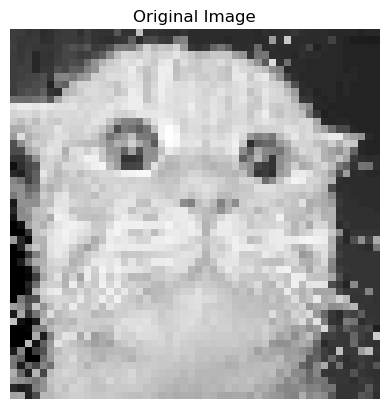

In [151]:
# 시각화
import matplotlib.pyplot as plt

# 입력 그림 
grayImg = grayT.squeeze()
plt.imshow(grayImg, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.show()

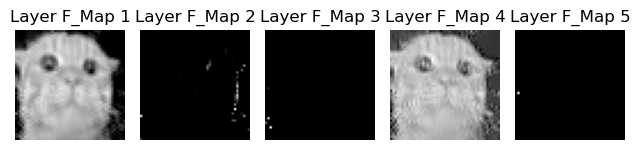

In [161]:
# 첫번째 Conv2D Layer 추출 피처맵
plt.subplot(1, 5, 1)

for idx in range(relu1.shape[0]):
    plt.subplot(1, 5, idx+1)
    plt.imshow(relu1[idx].detach(), cmap="gray") # grad연결되어 있어서 detach해줘야함 
    plt.title(f"Layer F_Map {idx+1}")
    plt.axis("off") # 축 제거
plt.tight_layout()
plt.show()

======== [First Layer] ========


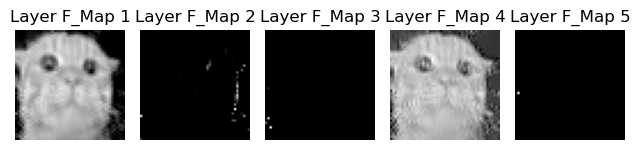

======== [Second Layer] ========


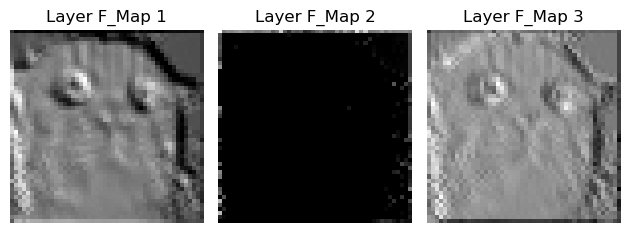

======== [Final Layer] ========


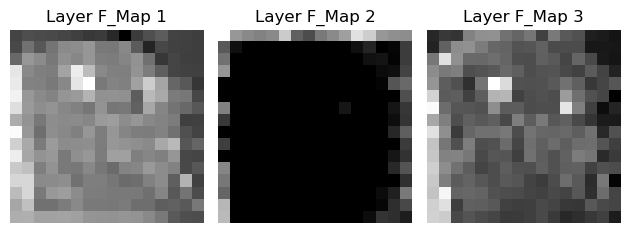

In [163]:
def print_featuremap(fm_tensor, cols, layer_name):
    print(f"======== [{layer_name} Layer] ========") # 제목 출력
    
    # 그래프 그리기
    for idx in range(fm_tensor.shape[0]):
        plt.subplot(1, cols, idx+1)
        plt.imshow(fm_tensor[idx].detach(), cmap="gray") # grad연결되어 있어서 detach해줘야함 
        plt.title(f"Layer F_Map {idx+1}")
        plt.axis("off") # 축 제거
    plt.tight_layout()
    plt.show() 
    
print_featuremap(relu1, 5, "First")
print_featuremap(relu2, 3, "Second")
print_featuremap(mp1, 3, "Final")